# Imports and other


In [ ]:
MODEL_VERSION = "theta"

In [ ]:
!pip install catalyst albumentations efficientnet_pytorch torchviz mlconfig fastprogress editdistance
clear_output()

In [ ]:
import numpy as np
import cv2
import math
import os
from efficientnet_pytorch.utils import get_same_padding_conv2d
import sys
import matplotlib.pyplot as plt
import re 
import random
from fastprogress.fastprogress import progress_bar
import pandas as pd
import logging
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from CTCDecoder.src.BestPath import ctcBestPath
from torch.utils.data import Dataset, DataLoader
from shutil import copyfile
from catalyst import dl, metrics
from evaluate import evaluate
from catalyst.data.cv import ToTensor
import torchvision.models as models
import torchvision.transforms as transforms
import typing as t
from torchviz import make_dot
from efficientnet_pytorch import EfficientNet
import albumentations as A

# Reproducibility


In [ ]:
SEED = 42
def set_seed(seed: int = 42, set_torch=True):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    if set_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False 
set_seed(SEED)

# Data preparation

In [ ]:
MAX_STR_LEN = 71
CHARS = [
    ' ', '(', ')', '+', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '[', 
    ']', 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 
    'p', 'r', 's', 't', 'u', '|', '×', 'ǂ', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 
    'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 
    'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ѣ', '–', '⊕', '⊗'
]
CTC_CHARS = CHARS + ['ϵ']  # introduce blank character

assert len(CHARS) == len(set(CHARS))

N_UNIQUE_CHARS = len(CHARS)
BLANK_IDX = N_UNIQUE_CHARS
N_UNIQUE_CTC_CHARS = len(CTC_CHARS)

def c2idx(char: str) -> int:
    assert char in CTC_CHARS, char
    return CTC_CHARS.index(char)

def idx2c(idx: int):
    assert idx < len(CTC_CHARS)
    return CTC_CHARS[idx]

def dir_pathes2df(image_dir, trans_dir) -> pd.DataFrame:
    df = pd.DataFrame({"imgpath": sorted(os.listdir(image_dir)), "textpath": sorted(os.listdir(trans_dir))})
    df["imgpath"] = image_dir + df["imgpath"] 
    df["textpath"] = trans_dir + df["textpath"] 
    return df

In [ ]:
IMAGE_SHAPE = (3, 224, 1868)

class CommonDataset(Dataset):
    def __init__(self, augs):
        augs = augs
        self.augs = augs
        self._transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])
    
    def transform(self, X) -> torch.FloatTensor:
        return self._transform(X).type(torch.FloatTensor)

    def __len__(self) -> int:
        return len(self.imgs) * len(self.augs)

    @staticmethod
    def read_text(textpath) -> str:
        with open(textpath, 'r') as f:
            return f.read()

    @staticmethod
    def _read_img(imgpath) -> np.array:
        return cv2.imread(imgpath)
        
    @staticmethod
    def preprocess_text(label) -> str:
        return label

    @staticmethod
    def text_to_labels(text, padlen=MAX_STR_LEN, pad_value=BLANK_IDX, left_pad=False):
        '''
        swaps characters and indexes, pads with pad_value
        PAD_VALUE THEN MUST BE REMOVED TO WORK
        '''
        labels = np.array(list(map(lambda x: c2idx(x), text)))
        l = len(labels)
        assert l <= padlen
        padding = np.full(padlen - l, pad_value)
        if left_pad:
            return np.concatenate((padding, labels))
        else:
            return np.concatenate((labels, padding))

    def whole_image_pipeline(self, img):
        return self.transform(self.preprocess_img(img))

    @staticmethod
    def preprocess_img(img):
        w, h,_ = img.shape
        if w > 2.5 * h:
            img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
            w, h = h, w
        new_w = IMAGE_SHAPE[1]
        new_h = int(h * (new_w / w))
        img = cv2.resize(img, (new_h, new_w))
        w, h,_ = img.shape
        img = img.astype('float32')
        if w < new_w:
            add_zeros = np.full((new_w - w, h, 3), 255)
            img = np.concatenate((img, add_zeros))
            w, h,_ = img.shape
        if h < IMAGE_SHAPE[2]:
            add_zeros = np.full((w, IMAGE_SHAPE[2] - h,3), 255)
            img = np.concatenate((img, add_zeros), axis=1)
            w, h,_ = img.shape

        if h > IMAGE_SHAPE[2] or w > new_w:
            dim = (IMAGE_SHAPE[2], IMAGE_SHAPE[1])
            img = cv2.resize(img, dim)

        img = cv2.subtract(255, img)
        img = img / 255
        return img
    
    def __getitem__(self, i) -> dict:
        aug_idx = i // len(self.imgs)
        i %= len(self.imgs)
        img, text = self.get_item(i)
        img = self.augs[aug_idx](image=img)["image"]
        img = self.preprocess_img(img)
        label = self.text_to_labels(self.preprocess_text(text))
        return {
            'image': self.transform(img),
            'label': torch.from_numpy(label).type(torch.LongTensor),
            'text': text
        }

class LazyDataset(CommonDataset):
    def __init__(self, df, augs=[]):
        super(LazyDataset, self).__init__(augs)
        self.imgs = df["imgpath"].values
        self.texts = df["textpath"].values
        logging.info(f'Creating dataset with {len(self.imgs)} examples')    

    def get_item(self, i):
        # returns raw image and text
        text_file = self.texts[i]
        img_file = self.imgs[i]
        text = self.read_text(text_file)
        img = self._read_img(img_file)
        return img, text

In [ ]:
if not os.path.exists("/data"):
    from checker import checker
    !sudo mkdir /data
    !sudo wget https://storage.yandexcloud.net/datasouls-ods/materials/46b7bb85/datasets.zip -P /data
    !sudo unzip /data/datasets.zip -d /data/
    !sudo rm /data/datasets.zip
    num_corr, num = checker("/data/train/words")
    cv2.imwrite("/data/train/images/221_10_23.jpg", cv2.rotate(cv2.imread("/data/train/images/221_10_23.jpg"), cv2.ROTATE_90_CLOCKWISE))
    # За эти замечания спасибо Сергею Злобину
    !printf 'вашему величеству лицеземной поклон' > /data/train/words/197_17_2.txt
    !printf 'ной прямую накрестъ линѣю как видима вцев' > /data/train/words/217_40_13.txt
    !printf '[около сих мѣстъ [на половинѣ' > /data/train/words/343_46_35.txt
    !printf 'явитца адмира' > /data/train/words/368_3_0.txt
    !printf '+ того же смотрѣт i въ воiнской амунициi' > /data/train/words/416_2_12.txt
    !printf 'i потом немедленно пришлите' > /data/train/words/47_27_5.txt
    !printf 'тотчас сие по воли' > /data/train/words/77_28_14.txt
    !printf 'ч' > /data/train/words/182_5_3.txt
    clear_output()
    print('\nSTATISTICS')
    print('Number of corrected files = ' + str(num_corr))
    print('Total number of files = ' + str(num))
    print('Percentage of corrected files = ' + str(np.round(num_corr/num * 100, 2)) + '%')

In [ ]:
image_dir = '/data/train/images/'
trans_dir = '/data/train/words/'

df = dir_pathes2df(image_dir, trans_dir)
def read_text(path):
    with open(path, 'r') as file:
        return file.read()
df["text"] = df["textpath"].apply(read_text)

contains_del_chars = lambda x: bool(set(x) - set(CHARS))
train_df, test_df = train_test_split(df, test_size=0.05, random_state=SEED)
train_df = train_df[~train_df["text"].apply(contains_del_chars)]
 
whole_dataset = LazyDataset(df, [A.NoOp()])
train_dataset = LazyDataset(train_df, [A.NoOp()])
test_dataset = LazyDataset(test_df, [A.NoOp()])

первое что г отютантъ вашъ сказывал что



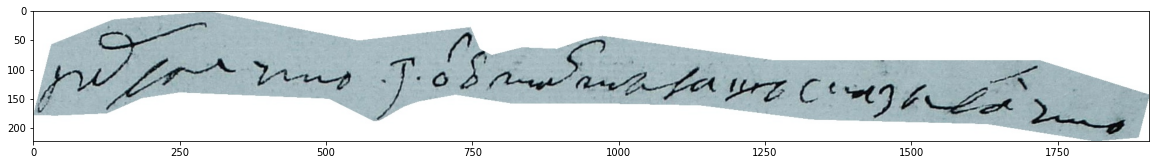

In [ ]:
example = random.choice(os.listdir(image_dir))
img = cv2.imread(image_dir+'/' + example)
with open(trans_dir + '/' + example[:-3] + 'txt', 'r') as f:
    example_text = f.read()
    print(example_text)
print()
plt.figure(figsize=(20, 7))
plt.imshow(img)
plt.show()

[53 43 54 40 52 43  0 61 56 52  0 41  0 52 56 68 56 38 51 56 64  0 40 38
 62 64  0 55 48 38 45 65 40 38 49  0 61 56 52 74 74 74 74 74 74 74 74 74
 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74 74]


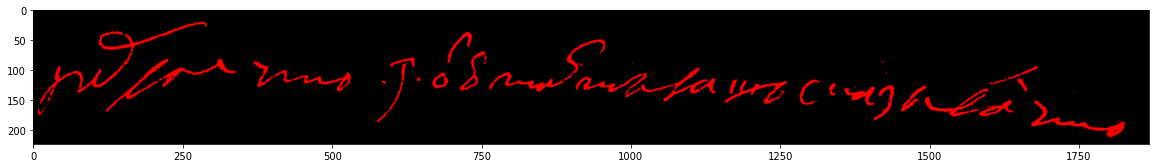

In [ ]:
i = train_dataset.whole_image_pipeline(img)
example_text_i = train_dataset.text_to_labels(example_text)
print(example_text_i)
plt.figure(figsize=(20, 7))
plt.imshow(i.permute(1, 2, 0).numpy())
plt.show()

# Modeling


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_output_shape(model, input_shape):
    input_shape = (1, ) + input_shape
    with torch.no_grad():
        return model(torch.rand(*input_shape)).shape[1:]


class EfficientNetFe(EfficientNet):
    def _stem_and_blocks_output(self, inputs):
        x = self._swish(self._bn0(self._conv_stem(inputs)))
        for idx, block in enumerate(self._blocks):
            drop_connect_rate = self._global_params.drop_connect_rate
            if drop_connect_rate:
                drop_connect_rate *= float(idx) / len(self._blocks) # scale drop connect_rate
            x = block(x, drop_connect_rate=drop_connect_rate)
        return x

    def get_blocks_shape(self, image_shape=IMAGE_SHAPE):
        return get_output_shape(self._stem_and_blocks_output, image_shape)

    def drop_last_n_layers(self, n):
        # specifies how much layers to drop from feature extractor
        if n != 0:
            self._blocks = self._blocks[:-n]
        new_output_shape = self.get_blocks_shape()
        self._conv_head = get_same_padding_conv2d(image_size=new_output_shape[1:])(
            new_output_shape[0], new_output_shape[0] * 4, self._conv_head.kernel_size
        )
        self._bn1 = nn.BatchNorm2d(new_output_shape[0] * 4)
        print("Output shape", get_output_shape(self, IMAGE_SHAPE))
        return self

    def forward(self, inputs):
        # Stem and Blocks
        x = self._stem_and_blocks_output(inputs)
        # Head
        x = self._swish(self._bn1(self._conv_head(x)))
        return x

In [ ]:
class OCRBackboneRnnModel(nn.Module):
    def __init__(self, config):
        super(OCRBackboneRnnModel, self).__init__()
        # backbone
        self.model_name = config["model_name"]
        self.backbone = config["backbone"]
        for param in self.backbone.parameters():
            param.requires_grad = config["train_backbone"]

        # lstm 
        self.pooling = nn.AdaptiveMaxPool2d((1, None))
        rnn_hidden_size = 256
        self.rnn = nn.LSTM(
            input_size=config["backbone_output_shape"][0], hidden_size=rnn_hidden_size, num_layers=2, 
            bidirectional=True, dropout=0.2
        )
        self.char_classifier = nn.Linear(rnn_hidden_size*2, N_UNIQUE_CTC_CHARS)

        self.ctc_decode = lambda mat: ctcBestPath(mat, CHARS)
        self.softmax = nn.Softmax(dim=2)
        self.log_softmax = nn.LogSoftmax(dim=2)
        print("N parameters", self.count_parameters())

    def forward(self, X):
        assert X.shape[1] in (1, 3), "Images must have 1 or 3 channels"
        features = self.backbone(X)
        timesteps = self.pooling(features).squeeze(2).permute(2, 0, 1) # [b, c, h, w] -> [w, b, c]
        rnn_output, h_n = self.rnn(timesteps)
        cla = self.char_classifier(rnn_output)
        return cla

    def _preds_to_probs(self, logits):
        # logits shape: [t, b, c]
        y_hat_for_decode = logits.transpose(0, 1)  # transpose makes: [t, b, c] -> [b, t, c]
        y_hat_for_decode = self.softmax(y_hat_for_decode)
        y_hat_for_decode = y_hat_for_decode.cpu().numpy()
        return y_hat_for_decode

    def predict(self, X):
        with torch.no_grad():
            y_hat = self.forward(torch.Tensor(X).to(device))
        
        y_hat_for_decode = self._preds_to_probs(y_hat)
        texts = [self.ctc_decode(mat) for mat in y_hat_for_decode] 
        return {"texts": texts, "raw": y_hat}

    def predict_dataset(self, X, bs=32):
        preds = []
        raws = []   
        for i in range(math.ceil(len(X) / bs)):
            p = self.predict(X[i*bs:(i+1)*bs])
            preds.extend(p["texts"])
            raws.extend(["raw"])
        return {"texts": preds, "raw": raws}

    def train(self, mode=True, train_bn=True):
        super(OCRBackboneRnnModel, self).train(mode)
        if not train_bn:
            for m in self.modules():
                if isinstance(m, nn.BatchNorm2d):
                    m.weight.requires_grad_(False)
                    m.bias.requires_grad_(False)
                    m.eval()

    def count_parameters(self, all=False):
        return sum(p.numel() for p in self.parameters() if (True if all else p.requires_grad))

In [ ]:
backbone = EfficientNetFe.from_name("efficientnet-b6")
backbone.load_state_dict(torch.load("pretrained_models/backbones/efficientnet/noisy-student-efficientnet-b6.pth"))
backbone.drop_last_n_layers(14)
train_config = {
    "backbone": backbone,
    "backbone_output_shape": get_output_shape(backbone, IMAGE_SHAPE),
    "train_backbone": True,
    "model_name": "ocr_model"
}
model = OCRBackboneRnnModel(train_config).to(device)
with torch.no_grad():
    o = model(i.unsqueeze(0).repeat(4, 1, 1, 1).to(device))      
print(o.shape)
del model, o, i
torch.cuda.empty_cache()

Output shape torch.Size([800, 14, 117])
N parameters 14130071
torch.Size([117, 4, 75])


In [ ]:
class BasicRunner(dl.Runner):
    def predict_batch(self, batch):
        # model inference step
        return self.model.predict(batch["image"].to(device))

    def _handle_batch(self, batch):
        # model train/valid step
        X, y, text = batch['image'], batch["label"], batch["text"]
        y_logits = self.model(X)  # [t, b, c]
        self.model.train(self.is_train_loader, False)

        '''Loss calculation'''
        log_probs = self.model.log_softmax(y_logits)  # make em logprob as the doc asks
        T, N, C = log_probs.shape # timesteps, batch_size, n_classes
        input_lengths = [T for i in range(N)]  # each has same n of timesteps
        target_lengths = [len(s) for s in text]
        y = y.flatten()  # make 1dim, the doc says we can do it
        y = y[y != BLANK_IDX]  # drop blank dims
        assert sum(target_lengths) == y.shape[0]
        l = loss(log_probs, y, input_lengths, target_lengths)
        if self.is_train_loader:
            l.backward()
        
        '''Bring it to text and calculate metrics'''
        pred_text = [self.model.ctc_decode(mat) for mat in model._preds_to_probs(y_logits.detach())]
        metrics = evaluate(text, pred_text)
        self.batch_metrics.update(
            {"loss": l, "cer": metrics["cer"], "wer": metrics["wer"], "sa": metrics["sa"]}
        )

        if (self.is_train_loader):
            if (ACCUMULATE_GRADIENT == 1) or (not (self.loader_step % (ACCUMULATE_GRADIENT - 1)) and (self.loader_step)):
                self.optimizer.step()
                self.optimizer.zero_grad()
                if self.scheduler and self.epoch > scheduler_start:
                    self.scheduler.step(self.epoch)

# Validation


In [ ]:
BATCH_SIZE = 3
ACCUMULATE_GRADIENT = 12 / BATCH_SIZE

whole_loader = DataLoader(whole_dataset, BATCH_SIZE, True)
train_loader = DataLoader(train_dataset, BATCH_SIZE, True)
test_loader = DataLoader(test_dataset, BATCH_SIZE, False)

loaders = {
    "train": train_loader,
    "valid": test_loader
}

In [ ]:
class BestCheckpointCallback(dl.CheckpointCallback):
    def _remove_old_checkpoints(self, logdir):
        try:
            cps = f"{logdir}/checkpoints/"
            test = os.listdir(cps)
            for item in test:
                if item.endswith(".pth"):
                    os.remove(os.path.join(cps, item))
        except:
            return

    def process_checkpoint(self, logdir, checkpoint, is_best, main_metric="loss", minimize_metric=True):
        if is_best:
            self._remove_old_checkpoints(logdir)
            _, filepath = self._save_checkpoint(
                logdir=logdir,
                checkpoint=checkpoint,
                suffix=self._get_checkpoint_suffix(checkpoint),
                is_best=is_best,
                is_last=True,
            )
            valid_metrics = checkpoint["valid_metrics"]
            checkpoint_metric = valid_metrics[main_metric]
            metrics_record = (filepath, checkpoint_metric, valid_metrics)
            self.top_best_metrics.append(metrics_record)
            self.metrics_history.append(metrics_record)
            self.truncate_checkpoints(minimize_metric=minimize_metric)
            metrics = self.process_metrics(valid_metrics)
            self._save_metric(logdir, metrics)
        
    def _get_checkpoint_suffix(self, checkpoint):
        result = f"model_{MODEL_VERSION}.{checkpoint['stage']}.{checkpoint['epoch']}"
        return result

In [ ]:
model = OCRBackboneRnnModel(train_config).to(device)
loss = nn.CTCLoss(blank=BLANK_IDX).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=7)
scheduler_start = 0

N parameters 14130071


In [ ]:
LOGDIR = f"logs_v{MODEL_VERSION}"
resume = None

callbacks = [
    dl.EarlyStoppingCallback(patience=25, metric="cer", minimize=True),
    BestCheckpointCallback(
        save_n_best=1,
        load_on_stage_start="best",
        metrics_filename=f"metrics_model{MODEL_VERSION}.json", 
        resume=resume
        )
]
runner = BasicRunner(device=device)
runner.train(
    model=model,                                                                                                                     
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,                                                                                                    
    num_epochs=300,
    timeit=True,
    verbose=False,
    logdir=LOGDIR,
    callbacks=callbacks,
    main_metric="cer",                                                      
    minimize_metric=True,
)

In [ ]:
copyfile(src=f"{LOGDIR}/checkpoints/best.pth", dst=f"pretrained_models/best_full_v{MODEL_VERSION}.pth")

## Check that model is all right


In [ ]:
backbone = EfficientNetFe.from_name("efficientnet-b6")
backbone.drop_last_n_layers(14)
train_config = {
    "backbone": backbone,
    "backbone_output_shape": get_output_shape(backbone, IMAGE_SHAPE),
    "train_backbone": False,
    "model_name": "ocr_model"
}

modelpath = f"pretrained_models/best_full_v{MODEL_VERSION}.pth"
best_model = torch.load(modelpath)
model = OCRBackboneRnnModel(train_config).to(device)
model.load_state_dict(best_model["model_state_dict"])
model.train(False, False);

Output shape torch.Size([800, 14, 117])
N parameters 3782219


In [ ]:
preds = []
true = [] 
for b in progress_bar(iter(test_loader)):
    preds.extend(model.predict_dataset(b["image"], BATCH_SIZE)["texts"])
    true.extend(b["text"])
print(evaluate(true, preds, 1))

Character error rate: 4.202719%
Word error rate: 25.906736%
String accuracy: 44.838710%
{'cer': 4.202719406674907, 'wer': 25.906735751295333, 'sa': 44.83870967741935}


## Fit it on test before submission

In [ ]:
for p in model.parameters():
    p.requires_grad = True
model.train(True, False)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
FIT_VALID_EPOCHS = 3

runner = BasicRunner(device=device)
runner.train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders={"train": test_loader},
    num_epochs=FIT_VALID_EPOCHS,
    timeit=True,
    verbose=True,
    main_metric="cer",                                                      
    minimize_metric=True,
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

runner = BasicRunner(device=device)
runner.train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders={"train": whole_loader},
    num_epochs=1,
    timeit=True,
    verbose=True,
    main_metric="cer",                                                      
    minimize_metric=True,
)

In [ ]:
torch.save(
    {"model_state_dict": model.state_dict()},
    f"pretrained_models/post_best_full_v{MODEL_VERSION}.pth"
)

In [ ]:
backbone = EfficientNetFe.from_name("efficientnet-b6")
backbone.drop_last_n_layers(14)
train_config = {
    "backbone": backbone,
    "backbone_output_shape": get_output_shape(backbone, IMAGE_SHAPE),
    "train_backbone": False,
    "model_name": "ocr_model"
}

modelpath = f"pretrained_models/post_best_full_v{MODEL_VERSION}_fifth.pth"
best_model = torch.load(modelpath)
model = OCRBackboneRnnModel(train_config).to(device)
model.load_state_dict(best_model["model_state_dict"])
model.train(False, False);

Output shape torch.Size([800, 14, 117])
N parameters 3782219


In [ ]:
preds = []
true = []
for b in progress_bar(iter(test_loader)):
    preds.extend(model.predict_dataset(b["image"], BATCH_SIZE)["texts"])
    true.extend(b["text"])
print(evaluate(true, preds, 1))

Character error rate: 1.594561%
Word error rate: 10.103627%
String accuracy: 70.322581%
{'cer': 1.5945611866501854, 'wer': 10.103626943005182, 'sa': 70.3225806451613}
